In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import torchvision.models as models
from PIL import Image
from torchvision.transforms import ToTensor
import pandas as pd
import json
import pickle
import numpy as np
from copy import deepcopy
from torchvision.utils import save_image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from flashtorch.activmax import GradientAscent
import flashtorch
from flashtorch.activmax import GradientAscent
from flashtorch.utils import standardize_and_clip,format_for_plotting
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torchvision import datasets
from os.path import join
from pathlib import Path
from shutil import copyfile
import warnings
warnings.simplefilter('ignore')


import sys
import os
%load_ext autoreload
%autoreload 2

sys.path.insert(1, './lib/pytorch-cnn-visualizations/src/')
from cnn_layer_visualization import CNNLayerVisualization
from guided_backprop import GuidedBackprop
from misc_functions import save_gradient_images

from IPython.display import clear_output

## Global Variables

In [2]:
# allow to run reduced computations
SINGLE_LAYER = True
#number of filters we compute images for
N_REDUCE = 22
#path to the numb image
NUMB_PATH = "./data/tinyimagenet/numb.png"

## Check labels

In [3]:
import pandas as pd
import os
labels_df = pd.read_csv('./data/tinyimagenet/labels.txt', sep=" ", header=None)
labels_df.rename(columns = {0:'id',1:'label',2:'name'},inplace = True)
present_df = pd.DataFrame(os.listdir('./data/tinyimagenet/train/'))
all_label_present = present_df[present_df[0].isin(labels_df['id'])].shape[0] == present_df.shape[0]
print("All labels are present in the list: {}".format(all_label_present))
labels_df.set_index('id',inplace = True)
dic_label = labels_df.name.to_dict()

All labels are present in the list: True


## Process Data

In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    allows to iterate with (datas,labels,paths)
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
model = models.vgg16(pretrained=True)
preprocess = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
    ,transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
my_dataset = ImageFolderWithPaths('./data/tinyimagenet/train/',transform=preprocess)

CLASS2INDX = my_dataset.class_to_idx
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=3, shuffle=True)

## Random unit test

In [6]:
def vis(tens):
    """
    if (type(tens) == PIL.JpegImagePlugin.JpegImageFile):
        plt.imshow(ToTensor()(tens).permute(1,2,0))
    else:
    """
    plt.imshow(tens.permute(1,2,0))

'bustard'

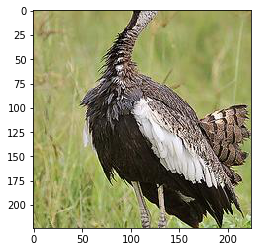

In [7]:
img_path='./data/exsmallimagenet/n02018795/n02018795_3564.JPEG'
test_image = Image.open(img_path)
#image = ToTensor()(image).unsqueeze(0)

vis(ToTensor()(test_image))

idx_to_class = {v:k for k,v in my_dataset.class_to_idx.items()}
label = model(preprocess(test_image).unsqueeze(0)).argmax().item()
classo = idx_to_class[label]
dic_label[classo]

## Model

In [8]:
g_ascent = GradientAscent(model.features)

#number of favourites images per filter
N_FAV = 4

In [9]:
def build_model(model):
    model_info = []
    #construct the data structure
    for layer in list(model.features.named_children()):
        layer_dic = {'ind':layer[0],
                  'lay':layer[1],
                  'name':str(layer[1]).split('(')[0] + "_" + str(layer[0]) 
                }
        if (type(layer_dic['lay']) == nn.Conv2d):     
            n_input = layer_dic['lay'].in_channels
            n_output = layer_dic['lay'].out_channels
            layer_dic['n_input'] = n_input
            layer_dic['n_output'] = n_output
            layer_dic["filters"] = []
            for i in range(n_output):
                layer_dic["filters"].append({
                    "id":i,
                    "fav_imgs":[NUMB_PATH for i in range(N_FAV)],
                    "grad_path":[NUMB_PATH for i in range(N_FAV)],
                    "spikes":[0 for i in range(N_FAV)],
                    "actmax_im":NUMB_PATH
                })
        elif (type(layer_dic['lay']) == nn.Linear):
                n_input = layer_dic['lay'].in_features
                n_output = layer_dic['lay'].out_features
                layer_dic['n_output'] = n_output
                #layer_dic["filters"] = [empty_filter.copy() for i in range(n_output)]
        model_info.append(layer_dic)
    return model_info

In [10]:
def save_to_json(model_info):
    model_info2 = deepcopy(model_info)
    for lay_info in model_info2:
         #TODO: sort the output
        """
        if type(lay_info['lay'] == nn.Conv2d):
            for filt in lay_info["filters"]:
                order = np.argsort(filt["spikes"])[::-1]
                filt["spikes"] = filt["spikes"][order]
                filt["fav_imgs"] = filt["fav_imgs"][order]
        """
        del lay_info['lay']
    with open('saved_model/test_model.json', 'w') as fout:
        json.dump(model_info2, fout, indent = 2)
    print("done!") 

In [11]:
model_info = build_model(model)

## Favorite images

In [91]:
def update_favims_model(model_info,data_loader,verbose = False):
    """
    update all the layers of the model_info such that each filter of each layer knows what are
    its favourite images (write it down in json)
    """
    for j,(datas,labels,paths) in enumerate(data_loader):
        for i,lay_info in enumerate(model_info):
            clear_output(wait=True)
            if verbose:
                print("Layer{}/{}:{:.2f} %..".format(i,len(model_info),100*j/ len(data_loader)))
            if (i>0 and SINGLE_LAYER):
                break
            datas = lay_info['lay'](datas)
            batch_size = datas.size(0)
            filter_nb = datas.size(1)
            #spikes = datas.view([batch_size,filter_nb,-1]).mean(dim = 2)
            spikes = datas.view([batch_size,filter_nb,-1]).max(dim = 2)[0]
            #TODO remove the second condition
            if  isinstance(lay_info['lay'],nn.Conv2d):
                update_filters_favim(lay_info,spikes,paths)    
            #save the whole model
    save_to_json(model_info)

def update_filters_favim(lay_info,batch_spikes,paths):
    #as many spikes in batch_spikes as there are samples in batch
    for spikes,path in zip(batch_spikes,paths):
        #at this stage there are as many spike in spikes as there are filters
        for k,(filt,spike) in enumerate(zip(lay_info["filters"],spikes.detach().numpy())):
            #TODO remove the condition
            if k >N_REDUCE and SINGLE_LAYER:
                break
            #compute the minimum spike for the filter
            min_indx = np.argmin(filt["spikes"])
            min_spike = min(filt["spikes"])
            if (spike > min_spike):
                filt["fav_imgs"][min_indx] = path
                filt["spikes"][min_indx] = float(spike)
            
def get_filt_string(layer_name,filter_id):
    """
    return the path to the max-activ-image for a given filter
    """
    return "./img_folder/max_activ/{0}_{1}.png".format(layer_name,filter_id)

In [ ]:
update_favims_model(model_info,train_loader,verbose = True)

## Compute the max-act-imgs

In [17]:
def compute_imgs_model(model_info):
    """
    compute and save the filter max-activations-images for each layer (Watch out, very expensive)
    """
    for lay_info in model_info:
        if (type(lay_info["lay"]) == nn.Conv2d):
            compute_imgs_layer(lay_info)
    save_to_json(model_info)

            
def compute_filter_actmax(lay_info,indexes = None):
    """
    compute  and save the filter maximal activation as an image. Compute it only for filters for which
    it has not been computed yet: delte the existing image for a refresh.
    """
    if indexes is None:
        indexes = range(lay_info["lay"].out_channels)
    layer_name = lay_info["name"]
    pre_existing = []
    for filt in lay_info["filters"]:
        filt_str = get_filt_string(lay_info["name"],filt["id"])
        try:
            f = open(filt_str)
            pre_existing.append(filt["id"])
        except FileNotFoundError:
            pass
    
    indexes = [i for i in indexes if i not in pre_existing]
    act_max_imgs = g_ascent.visualize(lay_info["lay"], indexes, title='conv5_1',return_output=True);
    
    save_filter_actmax(act_max_imgs,layer_name,indexes)
    
    #save the model_info
    if (type(lay_info['lay']) == nn.Conv2d):
        #load imgs: check for their presence
        for filt in lay_info['filters']:
            filt_str = get_filt_string(lay_info["name"],filt["id"])
            try:
                f = open(filt_str)
                filt["actmax_im"] = filt_str
                f.close()
            except FileNotFoundError:
                pass
                #print("File not accessible in {}".format(filt_str))                    
    
def save_filter_actmax(imgs,layer_name,indexes):
    """
    save the filter maximal activation pattern
    """
    #TODO: create folders for each layer
    for ind,img in zip(indexes,imgs):
        file_name = get_filt_string(layer_name,ind)
        p= standardize_and_clip(img.squeeze(0),saturation = 0.15,brightness = 0.7)
        save_image(p,file_name)

In [ ]:
# test for a few filters
compute_filter_actmax(model_info[28],list(range(N_REDUCE)))
compute_filter_actmax(model_info[0])
save_to_json(model_info)

## Compute the gradients for the favourite images

In [18]:
def save_gradient_images(gradient,path):
    """
    saves the gradient as a jpg image
    Args:
        gradient (torch.Tensor):
    """
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    im = transforms.ToPILImage()(gradient.squeeze(0))
    im.save(path)

In [19]:
def compute_grads(gbp,model_info,origin_path,verbose = False):
    """
    compute the gradients for the fav images of all filters of all layers for the model_info
    Args:
        gbp (GuidedBackprop): fitted on the model
        model_info (dic): as described above
        origin_path (str): path where to store the folders containing the gradient images
    """
    origin_path = os.path.join(origin_path,"gradients")
    Path(origin_path).mkdir(parents=False, exist_ok=True)
    for i,lay_info in enumerate(model_info):
        if (i!=0 and i != 28 and SINGLE_LAYER):
            continue
        #TODO: get rid of this enum
        if (type(lay_info['lay']) == nn.Conv2d):
            subdir_path = os.path.join(origin_path,lay_info['name'])
            Path(subdir_path).mkdir(parents=False, exist_ok=True)
            for j,filt in enumerate(lay_info['filters']):
                clear_output(wait=True)
                if verbose:
                    print("Layer {}/{}: {:.2f}%..".format(i+1,len(model_info),100*j/len(lay_info['filters'])))
                subdir_path2 = os.path.join(subdir_path,str(filt["id"]))
                Path(subdir_path2).mkdir(parents=False, exist_ok=True)
                compute_grads_filt(gbp,filt,subdir_path2)
    #now we changed the entries for the filters (grad_path)
    save_to_json(model_info)

In [20]:
def compute_grads_filt(gbp,filt,filt_path):
    """
    compute the gradients wrt to the favourite images of a filter filt.
    Args:
        gbp (GuidedBackprop): fitted on the model
        filt (dic): filter from a layer
        filt_path (str): path to the folder where to store the gradient images
    """
    for i,img_path in enumerate(filt["fav_imgs"]):
        if (img_path == NUMB_PATH):
            break
        image = Image.open(img_path)
        image = preprocess(image).unsqueeze(0)
        image.requires_grad = True
        jpg_name = img_path.split("/")[-1]
        class_name = jpg_name.split("_")[0]
        img_name = jpg_name.split(".")[0] + "_grad.jpg"
        guided_grads = gbp.generate_gradients(image,CLASS2INDX[class_name])
        grad_path = os.path.join(filt_path,img_name)
        filt["grad_path"][i] = grad_path
        save_gradient_images(guided_grads,grad_path)

In [ ]:
#TODO: use the class layer_activation_with_guided_backpropb
gbp = GuidedBackprop(model)
origin_path = "./img_folder/"
compute_grads(gbp,model_info,origin_path,verbose=True)

# Unit tests

## Activations

Trying to understand what expression the activation max try to optimize: seems like it is the mean.

In [ ]:
layer_indx = 0
img_indx =0
path ='./img_folder/max_activ/Conv2d_{}_{}.png'.format(layer_indx,img_indx)
image = Image.open(path)
image = preprocess(image).unsqueeze(0)
for i,lay_info in enumerate(model_info):
    if i > indx:
        break
    image = lay_info['lay'](image)
        
spikes = image.squeeze(0)
spikes = spikes.view([spikes.size(0),-1])
#maxo = spikes.max(dim=1)[0]
#maxo = spikes.norm(dim=1)
maxo = spikes.mean(dim=1)
plt.bar(range(maxo.size(0)),maxo.detach().numpy())

In [ ]:
layer_indx = 0
img_indx =3
layer_vis = CNNLayerVisualization(model.features,layer_indx, img_indx)
image = layer_vis.visualise_layer_without_hooks()
for i,lay_info in enumerate(model_info):
    if i > indx:
        break
    image = lay_info['lay'](image)
spikes = image.squeeze(0)
spikes = spikes.view([spikes.size(0),-1])
maxo = spikes.mean(dim=1)
plt.bar(range(maxo.size(0)),maxo.detach().numpy())

In [ ]:
k.register_forward_hook()

# Others

## Deprojection

The "deprojection" allows to recover the part of the original image responsible for a slice at a given filter.

In [38]:
class Projector():
    def __init__(self,layers,N_in):
        self.N_in = N_in
        self.layers = layers
        self.projs = self.get_chained_proj()
        
    @staticmethod
    def N_out(K,P,S,N_in):
        """
        return the output dimension given the input one for Conv2d or MaxPool2d
        """
        return (int((N_in+2*P-K)/S)+1)
    
    @staticmethod
    def get_slic (slic,S,P,K,N):
        """
        returns the equivalent slice for the input tensor of the filter
        Args:
            slic(tuple(tuple(int))): slices forthe
        """
        return (max(slic[0]*S-P,0),min(slic[1]*S +K-P,N))
    
    def get_deprojecter(self,layer,n):
        """
        return the projector for the given layer
        Args:
            layer(nn.Conv2d or nn.MaxPool2d): the layer you want a projecter for
            n(int): the side size of the input tensor (assumed to be squared) i.e the tensor
            is assumed to be (1x3xnxn)
        """
        K = layer.kernel_size
        P = layer.padding
        S = layer.stride
        if (isinstance(layer,nn.MaxPool2d)):
            return (lambda slices:(
                        Projector.get_slic(slices[0],S,P,K,n),
                        Projector.get_slic(slices[1],S,P,K,n)
                    ),
                    Projector.N_out(K,P,S,n)) #TODO: dont assume square image
        else:
            return (lambda slices:(
                        Projector.get_slic(slices[0],S[0],P[0],K[0],n),
                        Projector.get_slic(slices[1],S[1],P[1],K[1],n)
                    ),
                    Projector.N_out(K[0],P[0],S[0],n)) #TODO: dont assume square image
    
    def get_chained_proj(self):
        """
        Returns the projectors that will be used for the chaining
        """
        #non recursive call
        N = self.N_in
        projs = []
        for layer in self.layers:
            proj,N_out = self.get_deprojecter(layer,N)
            projs.append(proj)
            N = N_out
        return projs
    
    def chain(self,slices):
        """
        return the slice in the original image which induced the slice slices
        Args:
            slices(tuple(tuple(int))): the slices in the output as ((x1,x2),(y1,y2))
        """
        for proj in self.projs[::-1]:
            slices = proj(slices)
        return slices
    
    def viz(self,slices):
        """
        Visualize the slices effects amongst all the intermediate filters for the given Projector
        """
        #layers_copy = deepcopy(self.layers)
        self.layers_copy = self.layers
        imgs = [torch.zeros([1,3,self.N_in,self.N_in])]
        
        for layer in self.layers:
            if isinstance(layer,nn.Conv2d):
                layer2 = nn.Conv2d(3,3,layer.kernel_size,layer.stride,layer.padding)
                imgs.append(layer2(imgs[-1]))
            else:
                imgs.append(layer(imgs[-1]))
        
        assert(len(self.projs) == len(imgs)-1)
        for proj,img in zip(self.projs[::-1],imgs[::-1]):
            (x1,x2),(y1,y2) = slices
            img[0,:,x1:x2+1,y1:y2+1] = 255
            slices = proj(slices)
        (x1,x2),(y1,y2) = slices
        imgs[0][0,:,x1:x2+1,y1:y2+1] = 255
        
        dim = int(np.floor(np.sqrt(len(self.layers))))+1
        fig,axes = plt.subplots(dim,dim,figsize=(10,10))
        for i,img in enumerate(imgs):
            a,b = np.unravel_index(i,(dim,dim))
            axes[a,b].imshow((img[0].detach().permute(1,2,0).numpy()).astype(np.uint8))
            axes[a,b].set_title(str(i))

In [39]:
layers = []
for lay_info in model_info:
    if (not isinstance(lay_info['lay'],(nn.Conv2d,nn.MaxPool2d))):
        continue
    layers.append(lay_info['lay'])
    lay_info['deproj'] = Projector(deepcopy(layers),224)

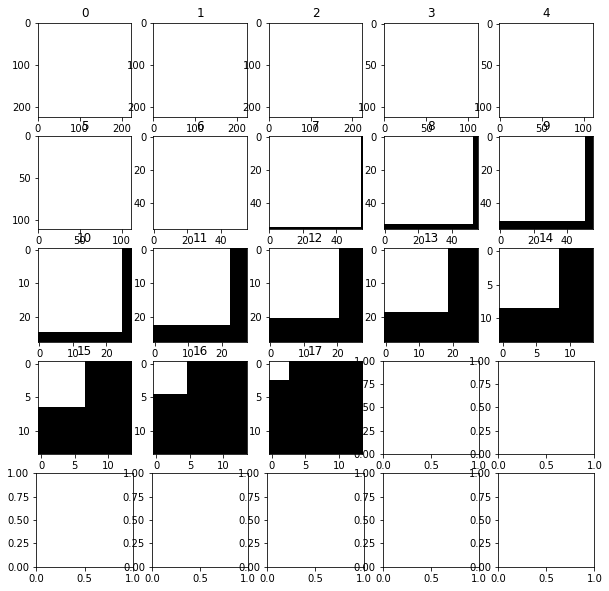

In [41]:
model_info[28]['deproj'].viz(((0,2),(0,2)))

In [2]:
def vis_arr(tens,ax=None):
    if ax is None:
        plt.imshow(tens.detach().permute(1,2,0))
    else:
        ax.imshow(tens.detach().permute(1,2,0))

In [108]:
templist = [layer1,layer2]
projs = get_chained_proj(templist,N_in)
f = lambda slices: call_chained_proj(projs,slices)

In [110]:
proj = Projector(templist,N_start)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


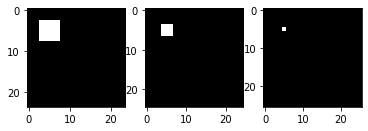

In [32]:
#with our model
N_start = 24
"""
K = layer.kernel_size[0]
P = layer.padding[0]
S = layer.stride[0] 
"""
#N_out = int((N_in + 2*P -K)/S) + 1

im_inp = torch.zeros([1,3,N_start,N_start])
layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=2,padding=1,stride=1) 
layer2 = nn.MaxPool2d(kernel_size=2,padding=1,stride=1)

proj1,N1 = get_deprojecter(layer1,N_start)
proj2,N2 = get_deprojecter(layer2,N1)

res1 = layer1(im_inp)
resout = layer2(res1)

slicout = ((5,5),(5,5))
slic2 = proj1(slicout)
slic1 = proj2(slic2)

(x1,x2),(y1,y2) = slic1
im_inp[0,:,x1:x2+1,y1:y2+1] = 255

(x3,x4),(y3,y4) = slic2
res1[0,:,x3:x4+1,y3:y4+1]= 255

(x5,x6),(y5,y6) = slicout
resout[0,:,x5:x6+1,y5:y6+1]= 255

fig,axes = plt.subplots(1,3)
vis_arr(im_inp[0],axes[0])
vis_arr(res1[0],axes[1])
vis_arr(resout[0],axes[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


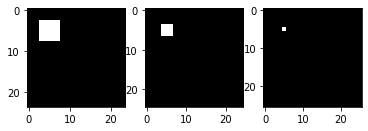

In [32]:
#areas
N_start = 24
"""
K = layer.kernel_size[0]
P = layer.padding[0]
S = layer.stride[0] 
"""
#N_out = int((N_in + 2*P -K)/S) + 1

im_inp = torch.zeros([1,3,N_start,N_start])
layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=2,padding=1,stride=1) 
layer2 = nn.MaxPool2d(kernel_size=2,padding=1,stride=1)

proj1,N1 = get_deprojecter(layer1,N_start)
proj2,N2 = get_deprojecter(layer2,N1)

res1 = layer1(im_inp)
resout = layer2(res1)

slicout = ((5,5),(5,5))
slic2 = proj1(slicout)
slic1 = proj2(slic2)

(x1,x2),(y1,y2) = slic1
im_inp[0,:,x1:x2+1,y1:y2+1] = 255

(x3,x4),(y3,y4) = slic2
res1[0,:,x3:x4+1,y3:y4+1]= 255

(x5,x6),(y5,y6) = slicout
resout[0,:,x5:x6+1,y5:y6+1]= 255

fig,axes = plt.subplots(1,3)
vis_arr(im_inp[0],axes[0])
vis_arr(res1[0],axes[1])
vis_arr(resout[0],axes[2])

## Recreate 1-1000 image subfolders

In [ ]:
target_path = "./data/exsmallimagenet"
src_path = "./data/tinyimagenet/train/"

Path(target_path).mkdir(parents=True, exist_ok=True)
for num_subfold,subfold in enumerate(os.listdir(src_path)):
    #TODO: erase that condition for full run
    #if num_subfold > 10:
    #    break
    subfold_trget_path = os.path.join(target_path,subfold)
    subfold_src_path = os.path.join(src_path,subfold)
    # create the directory
    Path(subfold_trget_path).mkdir(parents=True,exist_ok=True)
    for i,file in enumerate(os.listdir(subfold_src_path)):
        if i > 0:
            break
        copyfile(os.path.join(subfold_src_path,file),os.path.join(subfold_trget_path,file))

## Crop Images Cleanly

In [ ]:
crop_process = transforms.Compose([
    transforms.CenterCrop(224), 
])

In [ ]:
for i,(root, dirs, files) in enumerate(os.walk("./data/tinyimagenet/train/",topdown=False)):
    for name in files:
            path = os.path.join(root, name)
            image = Image.open(path)
            image = transforms.CenterCrop(224)(image)
            image.save(path)

## Check for b&w images

In [ ]:
from torchvision.utils import save_image
for i,(root, dirs, files) in enumerate(os.walk("./data/tinyimagenet/train//",topdown=False)):
    for name in files:
        path = os.path.join(root, name)
        image = Image.open(path)
        image = transforms.ToTensor()(image)
        if image.shape != torch.Size([3,224,224]):
            print(path)
            image = torch.stack([image,image,image],dim  =1).squeeze(0)
            assert(image.shape ==torch.Size([3,224,224]))
            save_image(image,path)

## Check files

In [ ]:
labels_df = pd.read_csv("./data/tinyimagenet/saved_tiny/labels.txt", sep=" ", header=None)
labels_df.rename(columns = {0:'id',1:'label',2:'name'},inplace = True)

presents_df = pd.DataFrame(os.listdir("./data/tinyimagenet/saved_tiny/train/"))

presents_df[presents_df[0].isin(labels_df['id'])].shape[0] == presents_df.shape[0]

In [ ]:
labels_df.set_index('id',inplace = True)

dic_label = labels_df['label'].to_dict()

In [ ]:
labels_df.name.apply(lambda x:x.lower()).values

## Deep_viz library

In [ ]:
import sys
import os

sys.path.insert(1, './pytorch-cnn-visualizations/src/')
from cnn_layer_visualization import CNNLayerVisualization
from guided_backprop import GuidedBackprop
%load_ext autoreload
%autoreload 2

In [ ]:
visualizer = CNNLayerVisualization(model.features,24,5)
#indeed works, save in a higher directory folder
visualizer.visualise_layer_with_hooks()

In [ ]:
model(image)

In [ ]:
gbp = GuidedBackprop(model)

#dummy image
img_path="./tinyimagenet/train/n01443537/images/n01443537_1.JPEG"
image = Image.open(img_path)
image = ToTensor()(image).unsqueeze(0)

image.requires_grad = True

guided_grads = gbp.generate_gradients(image,3)

plt.imshow(image[0].detach().permute(1,2,0))

In [ ]:
plt.imshow(guided_grads[0].permute(1,2,0))

In [ ]:
guided_grads.shape